In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

## 数据加载

In [4]:
import json
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

# 加载训练集和测试集
with open('test_set.json', 'r') as f:
    test_data = [json.loads(line) for line in f]

with open('train_set.json', 'r') as f:
    train_data = [json.loads(line) for line in f]

In [5]:
# 检查数据格式
print("训练集样本数：", len(train_data))
print("测试集样本数：", len(test_data))
print("样本示例：", train_data[0])  # 检查一个样本

训练集样本数： 1995
测试集样本数： 1996
样本示例： {'id': '1223', 'sex': 0, 'age': 0, 'race': 0.0, 'face': 0.0, 'prop': '', 'image': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

## 数据处理

In [7]:
class FaceDataset(Dataset):
    def __init__(self, data, transform=None):
        """
        自定义数据集类。
        :param data: 数据列表，每个元素是一个样本字典。
        :param transform: 数据变换（图像增强、归一化等）。
        """
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        
        # 提取图像和标签
        image = np.array(sample['image'], dtype=np.float32)  # 图像矩阵
        label = sample['sex']  # 示例标签为性别

        # 转换为 PyTorch 张量
        image = torch.tensor(image).unsqueeze(0)  # 添加通道维度 (1, 128, 128)
        label = torch.tensor(label, dtype=torch.long)  # 标签转换为整数
        
        # 应用图像变换（如果有）
        if self.transform:
            image = self.transform(image)

        return image, label

# 创建数据集和数据加载器
train_dataset = FaceDataset(train_data)
test_dataset = FaceDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 检查数据
images, labels = next(iter(train_loader))
print("图像批次大小：", images.size())  # 应为 (batch_size, 1, 128, 128)
print("标签批次大小：", labels.size())  # 应为 (batch_size,)


图像批次大小： torch.Size([32, 1, 128, 128])
标签批次大小： torch.Size([32])


## CNN模型

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # 定义卷积层
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        
        # 定义全连接层
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 2)  # 输出层，2 类（male 和 female）

        # 定义池化层
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 最大池化

    def forward(self, x):
        # 卷积层 + ReLU + 池化
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # 展平
        x = x.view(-1, 64 * 16 * 16)
        
        # 全连接层 + ReLU
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # 输出层
        
        return x


## 训练函数

In [11]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # 前向传播
            outputs = model(images)
            loss = criterion(outputs, labels)

            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 计算损失和准确率
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # 打印每个 epoch 的结果
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")


## 测试函数

In [13]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.2f}%")


## Main

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 训练模型
train_model(model, train_loader, criterion, optimizer, num_epochs=10)

# 测试模型
test_model(model, test_loader)


Epoch [1/10], Loss: 0.6869, Accuracy: 55.64%
Epoch [2/10], Loss: 0.6387, Accuracy: 61.45%
Epoch [3/10], Loss: 0.5434, Accuracy: 72.73%
Epoch [4/10], Loss: 0.4654, Accuracy: 76.69%
Epoch [5/10], Loss: 0.4135, Accuracy: 79.80%
Epoch [6/10], Loss: 0.3566, Accuracy: 83.91%
Epoch [7/10], Loss: 0.3178, Accuracy: 85.56%
Epoch [8/10], Loss: 0.2682, Accuracy: 88.37%
Epoch [9/10], Loss: 0.2350, Accuracy: 90.63%
Epoch [10/10], Loss: 0.2115, Accuracy: 91.13%
Test Accuracy: 79.31%


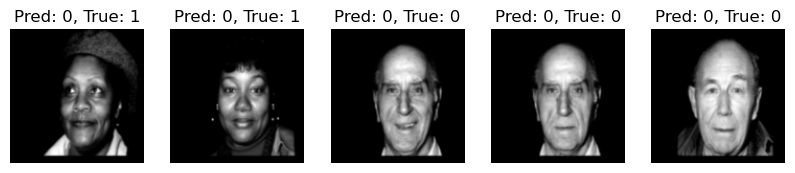

In [16]:
# 显示预测结果
model.eval()
images, labels = next(iter(test_loader))
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)

# 可视化
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Pred: {predicted[i].item()}, True: {labels[i].item()}")
    plt.axis('off')
plt.show()
